## Lab Realiable Systems Desing
## “Reliable weights” method for neural networks
## Jonathan Bizzi 1103546

In [ ]:
!pip install line_profiler
!pip install -q torchmetrics -U mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.6/717.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 58.3 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np

import torchmetrics
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

Let's use cuda if available

In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Let's fix a wider float display

In [ ]:
torch.set_printoptions(precision=12)

Define the dataloader to train the model

In [ ]:
def get_dataloaders(BATCH_SIZE_TRAIN, BATCH_SIZE_TEST):

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform_test)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

    return train_dataloader, test_dataloader, test_dataset

Define the accuracy function

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

This function displays a confusion matrix


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Model definition

In [ ]:
#Recursive block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, h_channels, stride):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, h_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(h_channels)
        self.conv2 = nn.Conv2d(h_channels, h_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(h_channels)
        self.relu = nn.ReLU()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != h_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, h_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(h_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

####-------------------------ResNet18 architecture-------------------------------####
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)
        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

    def _make_layer(self, block, h_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, h_channels, stride))
            self.in_channels = h_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out

In [ ]:
model = ResNet18(BasicBlock,[2,2,2,2]).to(device)

## Download and visualization of CIFAR10 dataset

100%|██████████| 170498071/170498071 [01:23<00:00, 2046663.36it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


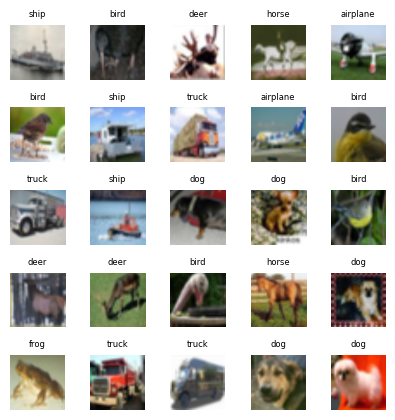

In [ ]:
transform = transforms.Compose([
    transforms.Resize((1000, 1000)),
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
classes = trainset.classes


indices = torch.randint(0, len(trainset), (100,))


fig, axes = plt.subplots(5, 5, figsize=(5, 5))


for i, ax in enumerate(axes.flat):
    # Ottieni l'immagine e l'etichetta
    image, label = trainset[indices[i]]
    ax.imshow(image.permute(1, 2, 0))
    ax.axis('off')
    ax.set_title(classes[label], fontsize=6)


plt.subplots_adjust(wspace=0.2, hspace=0.5)


plt.show()

In [ ]:
train_dataloader, test_dataloader, test_dataset= get_dataloaders(128,100)

Files already downloaded and verified
Files already downloaded and verified


## Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_loss=[]
acc_val=[]

The training part was commented in order to directly use the parameters already trained. In case you want to train it's enought to decomment the next 2 cells

In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(2)
"""
num_epochs = 112
for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch, (X,y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        ##X, y_train = batch
        y_pred=model(X) #forward pass
        loss = loss_fn(y_pred, y) #calculate the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # # Valutazione del modello sul set di test
    # model.eval()
    # correct = 0
    # total = 0
    # #accuracy= 0
    with torch.inference_mode():
      loss_loss.append(loss)
    #   for batch, (X,y) in enumerate(test_dataloader):
    #       X, y = X.to(device), y.to(device)
    #       y_pred = model(X)
    #       _, predicted = torch.max(y_pred, 1)
    #       total += y.size(0)
    #       correct += (predicted == y).sum().item()
    #       #accuracy += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    #   accuracy = (correct / total)*100
    #   acc_val.append(accuracy)
    #   #accuracy /= len(test_dataloader)
    # print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.4f}')

# Fine addestramento
"""

"\nnum_epochs = 112\nfor epoch in tqdm(range(num_epochs)):\n    model.train()\n    for batch, (X,y) in enumerate(train_dataloader):\n        X, y = X.to(device), y.to(device)\n        ##X, y_train = batch\n        y_pred=model(X) #forward pass\n        loss = loss_fn(y_pred, y) #calculate the loss\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    # # Valutazione del modello sul set di test\n    # model.eval()\n    # correct = 0\n    # total = 0\n    # #accuracy= 0\n    with torch.inference_mode():\n      loss_loss.append(loss)\n    #   for batch, (X,y) in enumerate(test_dataloader):\n    #       X, y = X.to(device), y.to(device)\n    #       y_pred = model(X)\n    #       _, predicted = torch.max(y_pred, 1)\n    #       total += y.size(0)\n    #       correct += (predicted == y).sum().item()\n    #       #accuracy += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))\n\n    #   accuracy = (correct / total)*100\n    #   acc_val.append(accuracy)\n  

In [ ]:
#dict_trained_net = model.state_dict()
#torch.save(dict_trained_net, 'parametri_rete.pth')
param = "/content/drive/MyDrive/lab_reliable/parametri_rete.pth"   #!!!!!!!! define the correct path from your drive
dict_trained_net = torch.load(param , map_location=torch.device(device))

## Binary Manipulation
Creating functions to display float in binary and creating the new mantissa

In [ ]:
import struct

def float_to_binary32(value):
    """Converts a float to a binary string representation."""
    [d] = struct.unpack('!I', struct.pack('!f', value))
    return f"{d:032b}"

def extract_parts(binary_str):
    """Extracts the sign, exponent, and mantissa from a binary string representation of a float."""
    sign = binary_str[0]
    exponent = binary_str[1:9]
    mantissa = binary_str[9:]
    return sign, exponent, mantissa

def manipulate_bits(sign, exponent, mantissa):
    """Manipulates the bits as described: taking the first 4 bits of the exponent and appending to the mantissa."""
    new_mantissa = mantissa[:19] + exponent[:4]
    return sign, exponent, new_mantissa

def binary32_to_float(binary_str):
    """Converts a binary string representation back to a float."""
    int_rep = int(binary_str, 2)
    return struct.unpack('!f', struct.pack('!I', int_rep))[0]

Try with a simple example

In [ ]:
# Example float
f = 0.15625
print("actual float", f)

# Convert the float to a binary string
binary_str = float_to_binary32(f)
print(f"Binary representation: {binary_str}")

# Extract the parts
sign, exponent, mantissa = extract_parts(binary_str)
print(f"Sign: {sign}, Exponent: {exponent}, Mantissa: {mantissa}")

# Manipulate the bits
new_sign, new_exponent, new_mantissa = manipulate_bits(sign, exponent, mantissa)
print(f"New Mantissa: {new_mantissa}")

# Combine the new parts into a new binary string
new_binary_str = new_sign + new_exponent + new_mantissa[:23]  # Ensure the mantissa is 23 bits long
print(f"New Binary representation: {new_binary_str}")

# Convert the new binary string back to a float
new_float = binary32_to_float(new_binary_str)
print(f"New float value: {new_float}")

actual float 0.15625
Binary representation: 00111110001000000000000000000000
Sign: 0, Exponent: 01111100, Mantissa: 01000000000000000000000
New Mantissa: 01000000000000000000111
New Binary representation: 00111110001000000000000000000111
New float value: 0.15625010430812836


Creating class that allows to get the new float, also allows to perform the manipulation on the entire tensor

In [ ]:
class RELIABLE_WEIGHTS():
  def __init__(self, x=1):
    self.x = x

  def float_to_binary32(self, value):
      [d] = struct.unpack('!I', struct.pack('!f', value))
      return f"{d:032b}"

  def extract_parts(self, binary_str):
      sign = binary_str[0]
      exponent = binary_str[1:9]
      mantissa = binary_str[9:]
      return sign, exponent, mantissa

  def manipulate_bits(self, sign, exponent, mantissa):
      new_mantissa = mantissa[:19] + exponent[:4]
      return sign, exponent, new_mantissa

  def binary32_to_float(self, binary_str):
      int_rep = int(binary_str, 2)
      return struct.unpack('!f', struct.pack('!I', int_rep))[0]

  def execute(self, my_float):
    c = self.float_to_binary32(my_float)
    s, e, m  = self.extract_parts(c)
    s, e, m = self.manipulate_bits(s, e, m)
    new_binary_str = s + e + m[:23]
    return self.binary32_to_float(new_binary_str)

  def apply_to_tensor(self, tensor):
        original_shape = tensor.shape
        linearized = tensor.view(-1)
        array = []
        for elem in linearized:
          new_el = self.execute(elem)
          array.append(new_el)
        new_lin = torch.tensor(array, dtype=torch.float32)
        return new_lin.view(original_shape)

create_rel_w = RELIABLE_WEIGHTS()

Let's try with a simple tensor

In [ ]:
f = [[1.00006, 0.23],[0.07006, 0.7308]]
f = torch.tensor(f)
nf = create_rel_w.apply_to_tensor(f)
print("Original tensor", f)
print("New tensor", nf)

Original tensor tensor([[1.000059962273, 0.230000004172],
        [0.070059999824, 0.730799973011]])
New tensor tensor([[1.000059962273, 0.229999884963],
        [0.070059947670, 0.730800092220]])


## Define some metrics
metrics to visualize the impact of this change in terms of time and RMS weights variation

In [ ]:
def calculate_rms(tensor1, tensor2):
    return torch.sqrt(torch.mean((tensor1 - tensor2) ** 2))

In [ ]:
import time

# test su un tensore
num_el = dict_trained_net['conv1.weight'].numel()
print("Number of tensor elements", num_el)

start_time = time.time()
new_weight = create_rel_w.apply_to_tensor(dict_trained_net['conv1.weight'])
end_time = time.time()

print(f"Execution time: {end_time - start_time} sec")
print("average time for element", (end_time - start_time)/num_el, "sec")

Number of tensor elements 1728
Execution time: 0.03208804130554199 sec
average time for element 1.8569468348114578e-05 sec


## Create the new dictionary with the realiable weights

In [ ]:
new_dict = dict_trained_net.copy()
tot_time = 0
num_el_tot = 0
for dicts in new_dict.keys():
  new_dict[dicts] = create_rel_w.apply_to_tensor(new_dict[dicts])
  print(dicts)
  num_el = new_dict[dicts].numel()
  num_el_tot += num_el
  print("Number of tensor elements", num_el)

  start_time = time.time()
  new_dict[dicts] = create_rel_w.apply_to_tensor(new_dict[dicts])
  end_time = time.time()
  tot_time += end_time - start_time
  print(f"Execution time: {end_time - start_time} sec")
  print("average time for element", (end_time - start_time)/num_el, "sec\n")


conv1.weight
Number of tensor elements 1728
Execution time: 0.00850534439086914 sec
average time for element 4.922074300271494e-06 sec

bn1.weight
Number of tensor elements 64
Execution time: 0.001354217529296875 sec
average time for element 2.1159648895263672e-05 sec

bn1.bias
Number of tensor elements 64
Execution time: 0.0007469654083251953 sec
average time for element 1.1671334505081177e-05 sec

bn1.running_mean
Number of tensor elements 64
Execution time: 0.0005939006805419922 sec
average time for element 9.279698133468628e-06 sec

bn1.running_var
Number of tensor elements 64
Execution time: 0.0014204978942871094 sec
average time for element 2.2195279598236084e-05 sec

bn1.num_batches_tracked
Number of tensor elements 1
Execution time: 0.0010852813720703125 sec
average time for element 0.0010852813720703125 sec

layer1.0.conv1.weight
Number of tensor elements 36864
Execution time: 0.346463680267334 sec
average time for element 9.398428826696343e-06 sec

layer1.0.bn1.weight
Number 

In [ ]:
torch.save(new_dict, 'nuovi_parametri_rete.pth')
new_reliable_dict = torch.load('nuovi_parametri_rete.pth', map_location=torch.device(device))

Let's see the metrics

In [ ]:
print("Total time required", tot_time, "sec")
print("Total number of elements", num_el_tot)
print("average time for element", tot_time/num_el_tot, "sec\n")

Total time required 62.96474504470825 sec
Total number of elements 11183582
average time for element 5.630105367377666e-06 sec



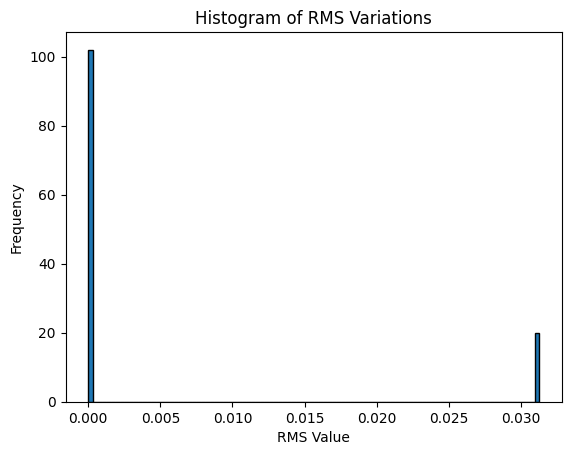

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Calculate the RMS for each pair of tensors and collect the results
rms_values = []
for key1, key2 in zip(new_reliable_dict.keys(), dict_trained_net.keys()):
    rms = calculate_rms(new_reliable_dict[key1], dict_trained_net[key2])
    rms_values.append(rms.item())

# Plot a histogram of the RMS variation
plt.hist(rms_values, bins=100, edgecolor='black')
plt.xlabel('RMS Value')
plt.ylabel('Frequency')
plt.title('Histogram of RMS Variations')
plt.show()


Let's see the distribution of RMS variations <0.005

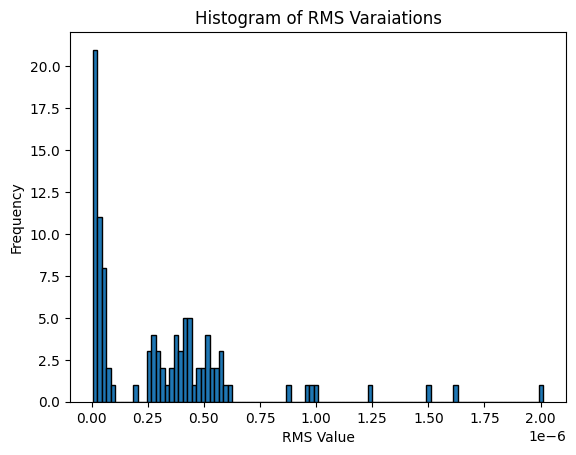

In [ ]:
rms_values_reduced = rms_values.copy()

for i, value in enumerate(rms_values_reduced):
  if (value > 0.005):
    rms_values_reduced.pop(i)

# Plotta un istogramma delle RMS
plt.hist(rms_values_reduced, bins=100, edgecolor='black')
plt.xlabel('RMS Value')
plt.ylabel('Frequency')
plt.title('Histogram of RMS Varaiations')
plt.show()


## Model accuracy with original weights

In [ ]:
model.load_state_dict(dict_trained_net)

<All keys matched successfully>

In [ ]:
y_preds=[]
y_predictions=[]
y_true_list = []
y_true = []
with torch.inference_mode():
  for batch, (X,y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    y_preds.append(y_pred.argmax(dim=1))
    y_true_list.append(y)
y_predictions=torch.cat(y_preds)
y_true=torch.cat(y_true_list)

In [ ]:
acc_original_weights = accuracy_fn(y_true, y_predictions)
print("Model accuracy with original weights", acc_original_weights)

Model accuracy with original weights 91.17


generate confusion matrix with original weights

In [ ]:
class_names = test_dataset.classes

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_predictions.cpu(),
                         target=torch.tensor(test_dataset.targets))
n_confmat = confmat_tensor.numpy()

## Model accuracy with realiable weights

In [ ]:
model.load_state_dict(new_reliable_dict)

<All keys matched successfully>

In [ ]:
y_preds_n=[]
y_predictions_n=[]
y_true_list = []
y_true = []
with torch.inference_mode():
  for batch, (X,y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_pred_n = model(X)
    y_preds_n.append(y_pred_n.argmax(dim=1))
    y_true_list.append(y)
y_predictions_n=torch.cat(y_preds_n)
y_true=torch.cat(y_true_list)

In [ ]:
acc_new_weights = accuracy_fn(y_true, y_predictions)
print("Model accuracy with realiable weights", acc_new_weights)

Model accuracy with realiable weights 91.17


generate confusion matrix with realiable weights

In [ ]:
class_names = test_dataset.classes

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor_n = confmat(preds=y_predictions_n.cpu(),
                         target=torch.tensor(test_dataset.targets))
n_confmat_rel = confmat_tensor_n.numpy()

## Plot the confusion matrices

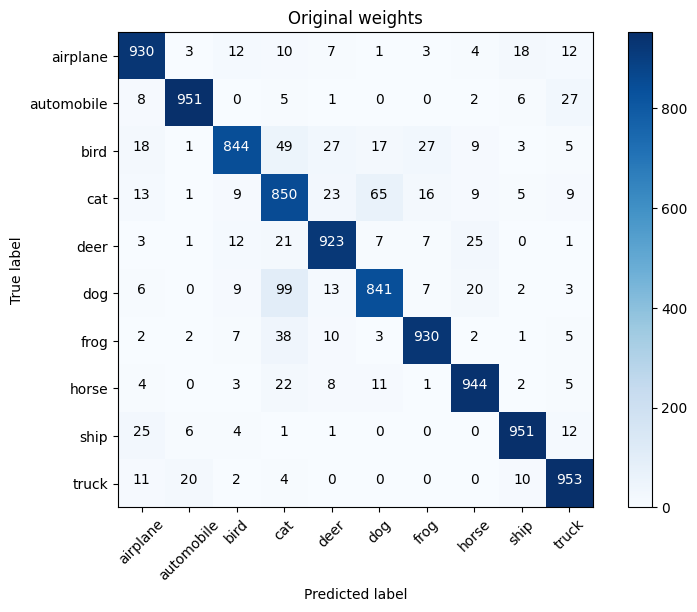

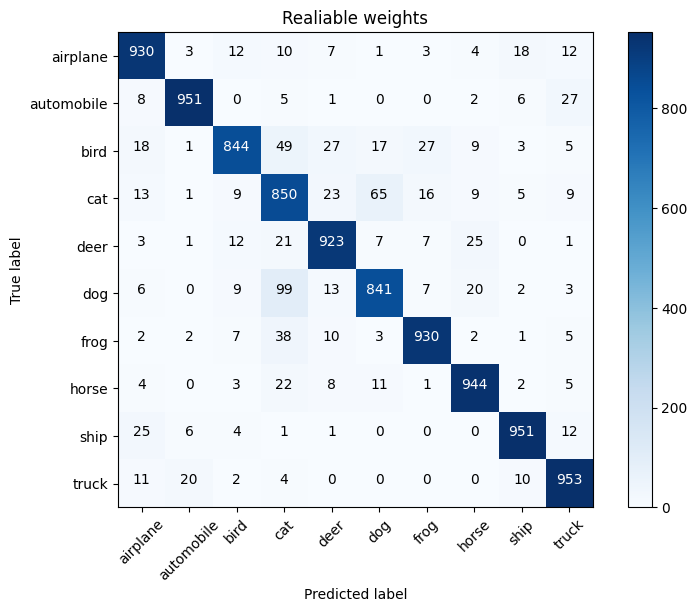

In [ ]:
#original
plt.figure(figsize=(8, 6))
plot_confusion_matrix(n_confmat, class_names)
plt.title('Original weights')
plt.show()

#new
plt.figure(figsize=(8, 6))
plot_confusion_matrix(n_confmat_rel, class_names)
plt.title('Realiable weights')
plt.show()